In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv("data/weight-height.csv")

data["height_cm"] = data["Height"]*2.54
data["weight_kg"] = data["Weight"]*0.453592
data = data.drop(["Height", "Weight"], 1)
data["factor"] = data.weight_kg / data.height_cm
data["Gender"] = data["Gender"].apply(lambda x: int(x == "Male"))

In [3]:
data.head()


,Gender,height_cm,weight_kg,factor
0,1,187.571423,109.720985,0.584956
1,1,174.706036,73.622732,0.421409
2,1,188.239668,96.497550,0.512631
3,1,182.196685,99.809504,0.547812
4,1,177.499761,93.598619,0.527317


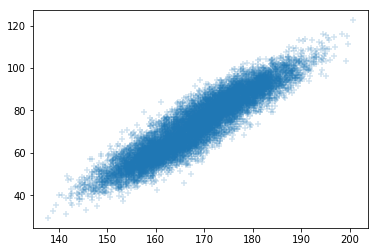

In [4]:
plt.scatter(data.height_cm, data.weight_kg, marker="+", alpha=0.2)

$$MSE= \frac{1}{N} \sum_{i=1}^{N} (y_i-y^*_i)^2 = \frac{1}{N} \sum_{i=1}^{N} (k*x_i+b-y^*_i)^2$$

$$y_i = k*x_i+b$$

$$MSE= \frac{1}{N} \sum_{i=1}^{N} (y_i-y^*_i)^2 = \frac{1}{N} \sum_{i=1}^{N} (k_1*x_{i1} + k_2*x_{i2} +b-y^*_i)^2$$

$$\nabla_k MSE = \frac{1}{N} \sum_{i=1}^{N} x_i*2*(k*x_i+b-y_i^*)$$
$$\nabla_b MSE = \frac{1}{N} \sum_{i=1}^{N} 2*(k*x_i+b-y_i^*)$$

$$(k_i, b_i) = (k_{i-1}, b_{i-1}) - \alpha * \left( \nabla_k MSE(k_{i-1}, b_{i-1}), \nabla_b MSE(k_{i-1}, b_{i-1}) \right)$$

# Создание тензоров в PyTorch



In [5]:
# Из списка
a = torch.tensor([[1,2,3,4], [5,6,7,8]], dtype=torch.float32)

In [6]:
# Из 1, по размеру равный a
torch.ones_like(a)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [7]:
# Из 0 заданного размера
torch.zeros(4,5)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
# Из случайных чисел размером 2x2x2x2
torch.randn(2,2,2,2)

tensor([[[[ 0.3058, -1.2082],
          [-1.5853, -1.1158]],

         [[ 0.6640,  2.0032],
          [ 0.2002, -0.4971]]],


        [[[-0.8506,  0.1756],
          [-0.3788,  0.7123]],

         [[-0.9863,  0.3926],
          [-1.5299, -0.1344]]]])

# Модель линейной регрессии

## Подготовка данных

In [9]:
X = data[["Gender", "height_cm"]].values
y = data["weight_kg"].values

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=data.Gender)

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

## Объявляем функцию ошибки

In [13]:
def MSE(X, y, k, b):
    tmp = (k @ X.T) + b - y
    return (1/X.shape[0] * (tmp @ tmp.T))

##  Обучение модели

In [14]:
k = torch.randn(1,2, dtype=torch.float32, requires_grad=True)
b = torch.randn(1, dtype=torch.float32, requires_grad=True)

In [15]:
losses = []

alpha = 1e-5

for i in range(1000):

    loss = MSE(X_train, y_train, k, b)
    loss.backward()
    losses.append(loss.cpu().item())
    
    k.data = k.data - alpha * k.grad
    b.data = b.data - alpha * b.grad

    k.grad.zero_()
    b.grad.zero_()

    

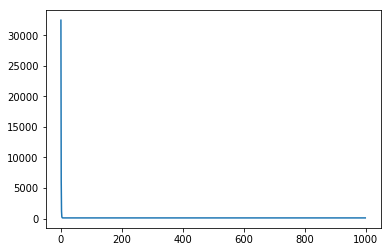

In [16]:
plt.plot(losses)

## Обучение с использованием оптимизатора

In [17]:
%%time
k = torch.randn(1,2, dtype=torch.float32, requires_grad=True)
b = torch.randn(1, dtype=torch.float32, requires_grad=True)

loss_f = torch.nn.MSELoss()
opt = torch.optim.Adam([k, b], lr=1e-1)

losses = []

for i in range(1000):
    out = (k @ X_train.T) + b
    loss = loss_f(out, y_train)
    loss.backward()
    
    losses.append(loss.detach().item())
    
    opt.step()
    opt.zero_grad()

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([8000])) that is different to the input size (torch.Size([1, 8000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Wall time: 619 ms


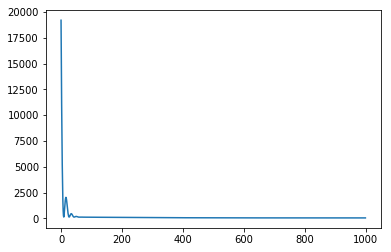

In [18]:
plt.plot(losses)

## Обучение с стандартными слоями на GPU

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
X_val = torch.tensor(X_val, dtype=torch.float32).cuda()
y_train = torch.tensor(y_train, dtype=torch.float32).cuda()
y_val = torch.tensor(y_val, dtype=torch.float32).cuda()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserW

In [20]:
linear = torch.nn.Linear(2, 1)
linear = linear.to("cuda")

In [21]:
%%time
loss_f = torch.nn.MSELoss()
opt = torch.optim.Adam(linear.parameters(), lr=1e-2)

losses = []

for i in range(1000):
    out = linear(X_train)
    loss = loss_f(out, y_train)
    loss.backward()
    
    losses.append(loss.detach().cpu().item())
    
    opt.step()
    opt.zero_grad()

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([8000])) that is different to the input size (torch.Size([8000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Wall time: 46.8 s


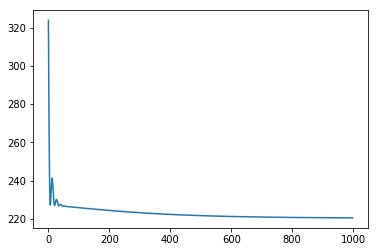

In [22]:
plt.plot(losses)